In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer

In [3]:
tl_core = 20.
tl_gap = 12.
tl_ground = 10.

resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

# Transmission line with resonator (failed version)

In [4]:
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)

# 2. Create main copler:

main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                            (coupler_start+coupler_length, central_line_y)],
                                   [resonator_core, resonator_ground, tl_core],[resonator_gap, resonator_gap, tl_gap, tl_gap],
                                   tl_ground, sample.layer_configuration, r=100)
sample.add(main_coupler)

# 3. Create fanout to create closed enfd of resonator
fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

# 4. 
g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=10, grounding_between = [(2,3)])

# 5. Create left part of transmission line
left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])

# 6. Create closed meander of resonator
closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                            meander_length=2300,restricted_scale=400, constant_scale=900, radius=0)

# 7. Create fanout to create closed enfd of resonator
fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

# 8. 
g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

# 9. Create left part of transmission line
right_TL = sample.connect_cpw(o1=p2, o2=g2, port1='port', port2='narrow', name='right TL', points=[])

# 10. Create closed meander of resonator
open_end_resonator = elements.CPW(name='open end resonator', points=[fanout_for_open_end.get_terminals()['down'].position, (fanout_for_open_end.get_terminals()['down'].position[0],
                                                                                                                    fanout_for_open_end.get_terminals()['down'].position[1]-1000)],
                                  w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
                                  g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
sample.add(open_end_resonator)
sample.connections.append(((fanout_for_open_end, 'down'), (open_end_resonator, 'port1')))

# 11. Create grounding of resonator
resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])

In [5]:
design = sample.draw_design()
watch()

C:\ProgramData\Anaconda3\envs\py38\lib\site-packages\gdspy\path.py:814: UserWarning: [GDSPY] Possible inconsistency found in `FlexPath` due to sharp corner.
  warnings.warn(
<ipython-input-2-1fe8b7b94d80>:1: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [37]:
gdspy.write_gds('1qubit.gds', cells=None, name='library', unit=1e-06, precision=1e-09, timestamp=None, binary_cells=None)

In [6]:
resonator_ground

RectGrounding resonator ground

In [6]:
sys, connections, elements_ = sample.get_tls()

In [9]:
connections

{(CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 0): 1,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 0): 1,
 (CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 1): 2,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 1): 2,
 (CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 2): 3,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 2): 3,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2),
  'center',
  0): 4,
 (RectGrounding cl1, 'wide', 0): 4,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2),
  'center',
  1): 5,
 (RectGrounding cl1, 'wide', 1): 5,
 (CPW "left TL", l=968.634, 'port1', 0): 6,
 (<QCreator.elements.pad.Pad at 0x2297ae18910>, 'port', 0): 6,
 (CPW "left TL", l=968.634, 'port2', 0): 7,
 (RectGrounding cl1, 'narrow', 0): 7,
 (CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port2', 0): 8,
 (RectFanout open end resonator fanout, n=3, grouping=(1

..\QCreator\general_sample_creator.py:250: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


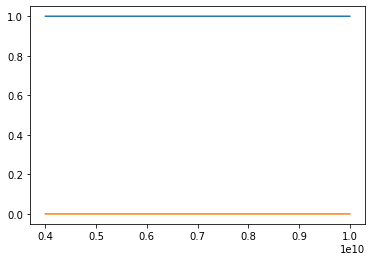

In [7]:
f = np.linspace(4e9, 10e9, 6001)
s11 = sample.get_s21('p1', 'p1', f)
s21 = sample.get_s21('p1', 'p2', f)
from matplotlib import pyplot as plt
plt.plot(f, np.abs(s11))
plt.plot(f, np.abs(s21))